In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt
from kerastuner import HyperParameters
import os
import matplotlib.pyplot as plt
import pickle

2024-05-18 10:20:00.107865: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-18 10:20:03.416532: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/tmp/ipykernel_6639/2028257283.py:9: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperParameters


In [2]:
df = pd.read_csv('processed_data.csv', infer_datetime_format=True, header = 0, parse_dates={'datetime':[0,1]}, index_col=['datetime'])
df.head()

/tmp/ipykernel_6639/2588014987.py:1: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv('processed_data.csv', infer_datetime_format=True, header = 0, parse_dates={'datetime':[0,1]}, index_col=['datetime'])
/tmp/ipykernel_6639/2588014987.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('processed_data.csv', infer_datetime_format=True, header = 0, parse_dates={'datetime':[0,1]}, index_col=['datetime'])


,co_gt,s1_co,c6h6_gt,s2_nhmc,nox_gt,s3_nox,no2_gt,s4_no2,s5_o3,temp,rh,ah
datetime,,,,,,,,,,,,
10/03/2004 18:00:00,0.396825,0.639299,0.356923,0.527016,0.191142,0.568345,0.445783,0.578780,0.504261,0.333333,0.489,0.280066
10/03/2004 19:00:00,0.301587,0.576568,0.280000,0.451372,0.117716,0.662670,0.361446,0.508223,0.355890,0.326882,0.477,0.264282
10/03/2004 20:00:00,0.333333,0.678044,0.267692,0.438071,0.150350,0.635492,0.449799,0.506101,0.407018,0.296774,0.540,0.276352
10/03/2004 21:00:00,0.333333,0.654059,0.273846,0.445553,0.198135,0.597122,0.481928,0.521485,0.471679,0.277419,0.600,0.294190
10/03/2004 22:00:00,0.238095,0.558118,0.190769,0.352452,0.150350,0.687450,0.457831,0.471618,0.425063,0.281720,0.596,0.295216


In [3]:
N_FEATURES = len(df.columns)
FEATURES_TO_SCALE = [f for f in df.columns if f != 'rh']

In [4]:
N_FEATURES

12

In [5]:
df.columns

Index(['co_gt', 's1_co', 'c6h6_gt', 's2_nhmc', 'nox_gt', 's3_nox', 'no2_gt',
       's4_no2', 's5_o3', 'temp', 'rh', 'ah'],
      dtype='object')

In [6]:
split = int(df.shape[0]*0.80)
train_df, test_df = df[:split], df[split:]

In [7]:
def split_series(series):
  """
  Splits data into samples of input past observations (one day before) and output future observations (current day).
  Returns a tuple of (X, y).
  """
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + 1
    future_end = past_end + 1

    if future_end > len(series):
      break

    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [8]:
X_train, y_train = split_series(train_df.values)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], N_FEATURES))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], N_FEATURES))

X_test, y_test = split_series(test_df.values)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], N_FEATURES))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], N_FEATURES))

In [31]:
# Definition of lstm model
def build_lstm_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(units=hp.Int('units', min_value=50, max_value=200, step=50), input_shape=(1, N_FEATURES)))
    model.add(tf.keras.layers.Dense(N_FEATURES))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(
        learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='linear', default=1e-3)),
        loss='mean_absolute_error') # use MAE as loss function
    
    return model

In [32]:
# Definition of lstm autoencoder model
def build_lstm_autoencoder_model(hp):
    encoder_inputs = tf.keras.layers.Input(shape=(1, N_FEATURES))
    encoder_l1 = tf.keras.layers.LSTM(units=hp.Int('units', min_value=50, max_value=200, step=50), return_state=True)
    encoder_outputs1 = encoder_l1(encoder_inputs)

    encoder_states1 = encoder_outputs1[1:]

    decoder_inputs = tf.keras.layers.RepeatVector(1)(encoder_outputs1[0])

    decoder_l1 = tf.keras.layers.LSTM(units=hp.Int('units', min_value=50, max_value=200, step=50), return_sequences=True)(decoder_inputs, initial_state=encoder_states1)
    decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(N_FEATURES))(decoder_l1)

    model = tf.keras.models.Model(encoder_inputs, decoder_outputs1)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
        hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='linear', default=1e-3)),
        loss='mean_absolute_error')  # use MAE as loss function
    
    return model

In [33]:
def tune_hyperparams(model_function, model_name):
    """
    Tunes hyperparameters of a given model as defined by `model_function`.
    Returns the retrained model using the best hyperparameter combination with regards to mean absolute error, and the training history for plotting loss.
    """

    # Instantiate a Keras tuner
    tuner = kt.RandomSearch(
        model_function,
        objective='val_loss',
        max_trials=5,
        executions_per_trial=2,
        directory='my_dir',
        project_name=model_name)

    # Print a summary of the search space
    tuner.search_space_summary()

    tuner.search(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=32)

    # Get the optimal hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

    for hp, val in best_hps.values.items():
        print(f"best {hp}: {val}")

    model = tuner.hypermodel.build(best_hps)
    history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=32)

    return model, history


In [34]:
def plot_loss(training_history):
    # Extract the loss values for each epoch
    train_loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.xticks(range(0, 20, 2))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [39]:
def test_model(model):
    """
    Prints mean absolute error test results of a given model against the test set
    """
    y_pred = model.predict(X_test)

    # Calculate MAE
    test_mae = mean_absolute_error(y_test.flatten(), y_pred.flatten())

    print(f'MAE: {test_mae}')

In [36]:
# First, evaluate a simple LSTM
lstm, lstm_history = tune_hyperparams(build_lstm_model, "lstm")

Trial 5 Complete [00h 00m 25s]
val_loss: 0.16996700316667557

Best val_loss So Far: 0.16299333423376083
Total elapsed time: 00h 02m 37s
best units: 50
best learning_rate: 0.0005600595784940353
Epoch 1/20


224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2463 - val_loss: 0.1610
Epoch 2/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1477 - val_loss: 0.1641
Epoch 3/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1464 - val_loss: 0.1672
Epoch 4/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1481 - val_loss: 0.1675
Epoch 5/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1458 - val_loss: 0.1690
Epoch 6/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1454 - val_loss: 0.1697
Epoch 7/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1461 - val_loss: 0.1663
Epoch 8/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1466 - val_loss: 0.1685
Epoch 9/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1462 - val_loss: 0.1692
Epoch 10/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1453 - val_loss: 0.1695
Epoch 11/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1463 - val_loss: 0.1695
Epoch 12/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.

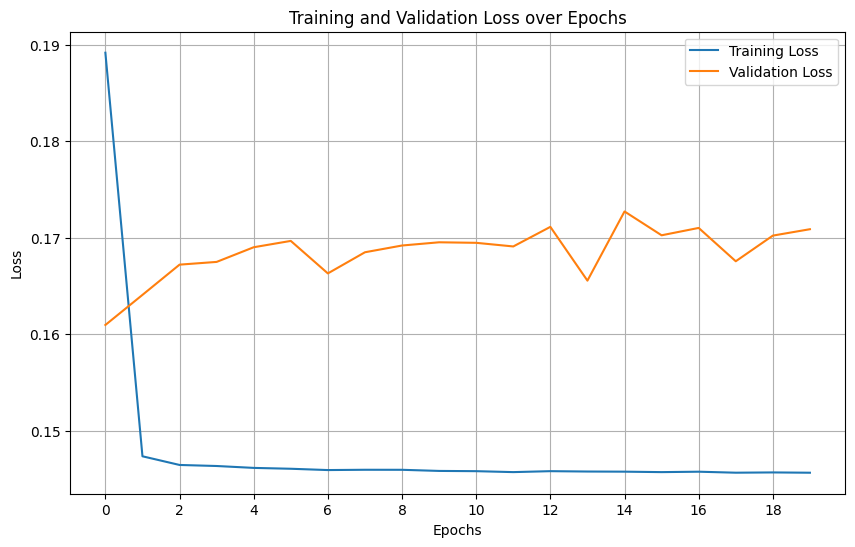

In [37]:
plot_loss(lstm_history)

From the learning curves, we can observe that the simple LSTM is severely underfitting the data. The model may not have a suitable capacity for the complexity of the dataset.

In [40]:
test_model(lstm)

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAE: 0.16835395811958387


Simple LSTM gives a final MAE score of approximately 0.168. Now, we can compare this performance against a more complex model, a Stacked LSTM sequence to sequence Autoencoder.

In [41]:
# Now, evaluate the LSTM autoencoder
lstm_autoencoder, lstm_autoencoder_history = tune_hyperparams(build_lstm_autoencoder_model, "lstm_autoencoder")

Reloading Tuner from my_dir/lstm_autoencoder/tuner0.json
Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 200, 'step': 50, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
best units: 200
best learning_rate: 0.00028925868757120307
Epoch 1/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2109 - val_loss: 0.0827
Epoch 2/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0686 - val_loss: 0.0674
Epoch 3/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0598 - val_loss: 0.0638
Epoch 4/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0572 - val_loss: 0.0601
Epoch 5/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0561 - val_loss: 0.0586
Epoch 6/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0550 - val_loss: 0.0572
Epoch 7/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0537 - 

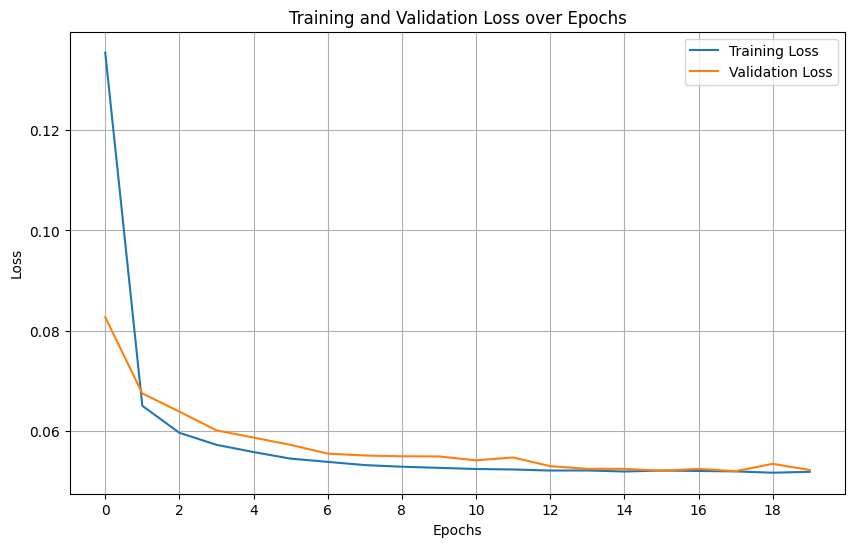

In [42]:
plot_loss(lstm_autoencoder_history)

The learning curve for the LSTM autoencoder model shows a good fit, as the training and validation losses that decrease to a point of stability with a minimal gap between the two final loss values.

In [43]:
test_model(lstm_autoencoder)

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MAE: 0.052131885220425986


To confirm the superiority of LSTM autoencoder over a simple LSTM, the former achieves a MAE test score of approximately 0.052!

In [44]:
# Load the scaler
with open('scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)

/opt/conda/envs/ds_env/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.4.1.post1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [45]:
# Test predictions with an array from the original scale
input_vals = np.array([0.5,921,1.9,575,95,956,58,1143,672,13.7,67.8,1.0575])
input_vals = input_vals.reshape(1, -1)
rh = input_vals[:, 10].reshape(-1, 1) 
input_vals = scaler.transform(input_vals[:, [i for i in range(input_vals.shape[1]) if i != 10]])
input_vals = np.insert(input_vals, 10, rh/100, axis=1)
print(input_vals)

input_arr = input_vals.reshape((1, 1, 12))

y_pred = lstm_autoencoder.predict(input_arr)
y_pred

[[0.06349206 0.23431734 0.04923077 0.1354946  0.10839161 0.48840927
  0.2248996  0.28753316 0.20551378 0.33548387 0.678      0.42652592]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/opt/conda/envs/ds_env/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


array([[[0.09006663, 0.24677247, 0.07467739, 0.19382699, 0.11276346,
         0.4740454 , 0.23680127, 0.2985784 , 0.22488509, 0.31669953,
         0.67644364, 0.41992757]]], dtype=float32)

In [46]:
y_pred = y_pred.reshape(-1, N_FEATURES)
# scale features except rh
input_to_invert = y_pred[:, [i for i in range(y_pred.shape[1]) if i != 10]]
print(input_to_invert.shape)
outputs = scaler.inverse_transform(input_to_invert)
print(outputs)
outputs = np.insert(outputs, 10, y_pred[:, 10], axis=1)

for feature, val in zip(df.columns, outputs.reshape(N_FEATURES)):
    print(f"{feature}: {val}")

(1, 11)
[[6.6741973e-01 9.3450134e+02 2.7270153e+00 6.4517383e+02 9.8751045e+01
  9.3803076e+02 6.0963516e+01 1.1638203e+03 7.1064575e+02 1.2826529e+01
  1.0439978e+00]]
co_gt: 0.6674197316169739
s1_co: 934.5013427734375
c6h6_gt: 2.727015256881714
s2_nhmc: 645.173828125
nox_gt: 98.75104522705078
s3_nox: 938.03076171875
no2_gt: 60.96351623535156
s4_no2: 1163.8203125
s5_o3: 710.645751953125
temp: 12.826528549194336
rh: 0.6764436364173889
ah: 1.0439977645874023


In [47]:
with open('lstm_autoencoder.pkl', 'wb') as f:
    pickle.dump(lstm_autoencoder, f)